# Advanced Pipeline – Robustness, HGB, Calibration

Objective: Train advanced models with missingness/noise injection, compare performance, and calibrate probabilities.


In [1]:
import os
import sys
import pandas as pd
import numpy as np
import joblib

sys.path.append(os.path.abspath(".."))

from src.config import RANDOM_STATE, N_SPLITS
from src.data_prep import inject_missingness_and_noise
from src.preprocessing import (
    build_train_test_split, build_advanced_preprocessor_median,
    build_advanced_preprocessor_knn
)
from src.modeling import (
    train_histgradientboosting, compare_models,
    calibrate_model, evaluate_on_test, compute_brier_score,
    compute_ece, compute_reliability_curve
)
from src.visualization import (
    plot_roc_curve, plot_pr_curve, 
    plot_calibration_summary
)
from sklearn.metrics import roc_curve, precision_recall_curve    
from src.evaluation import compute_bootstrap_intervals

In [2]:
# Prepare dataset with robustness augmentation
df = pd.read_csv("../data/processed/cardio_processed.csv")

df_aug, trace = inject_missingness_and_noise(df)
X_train, X_test, y_train, y_test = build_train_test_split(df_aug, random_state=RANDOM_STATE)

# Save missingness/noise trace
pd.DataFrame([trace]).to_csv("../reports/tables/robustness_trace.csv", index=False)

In [3]:
# Build advanced preprocessors
prep_median = build_advanced_preprocessor_median()
prep_knn = build_advanced_preprocessor_knn()

# Train HGB models
hgb_median, _ = train_histgradientboosting(prep_median, X_train, y_train, random_state=RANDOM_STATE)
hgb_knn, _ = train_histgradientboosting(prep_knn, X_train, y_train, random_state=RANDOM_STATE)

In [4]:
# Compare models
comp = compare_models(
    {"HGB+median": hgb_median, "HGB+knn": hgb_knn},
    X_train, y_train, random_state=RANDOM_STATE, n_splits=N_SPLITS
)

comp.to_csv("../reports/tables/model_comparison.csv", index=False)
comp

,model,imputation,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std
0,HGB,median,0.79546,0.003361,0.775851,0.004416
1,HGB,knn,0.79365,0.003818,0.773917,0.004733


In [5]:
# Calibration and test evaluation
calibrated = calibrate_model(hgb_median, X_train, y_train, method="isotonic")
joblib.dump(calibrated, "../models/final_pipeline.joblib")

test_cal = evaluate_on_test(calibrated, X_test, y_test)
pd.DataFrame([test_cal]).to_csv("../reports/tables/test_advanced_calibrated.csv", index=False)
df_test_cal = pd.DataFrame([{
    "model": "HGB",
    "imputation": "median",
    "roc_auc": test_cal["roc_auc"],
    "pr_auc": test_cal["pr_auc"]
}])

df_test_cal = df_test_cal.round(4)
df_test_cal

,model,imputation,roc_auc,pr_auc
0,HGB,median,0.789,0.7726


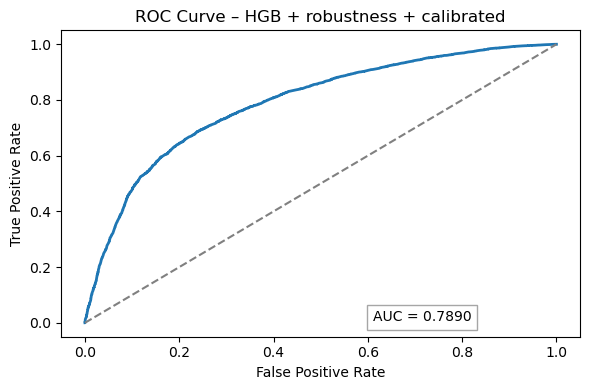

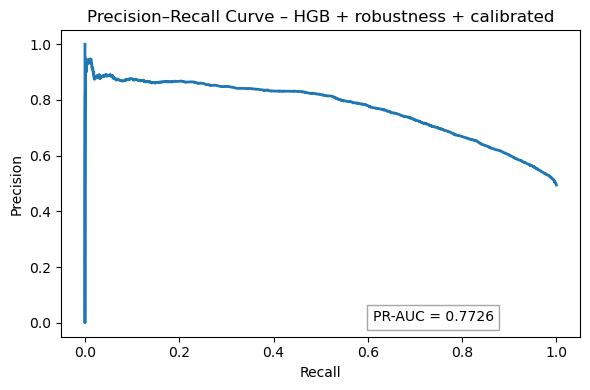

In [6]:
# Visualization
y_prob_hgb = calibrated.predict_proba(X_test)[:, 1]
fpr_hgb, tpr_hgb, _ = roc_curve(y_test, y_prob_hgb)
precision_hgb, recall_hgb, _ = precision_recall_curve(y_test, y_prob_hgb)

fig_roc_hgb = plot_roc_curve(fpr_hgb, tpr_hgb, auc_value=test_cal["roc_auc"], 
                             model_name="HGB + robustness + calibrated")

fig_pr_hgb = plot_pr_curve(precision_hgb, recall_hgb, pr_value=test_cal["pr_auc"], 
                           model_name="HGB + robustness + calibrated")

fig_roc_hgb.savefig("../reports/figures/roc_hgb_advanced.png", dpi=300)
fig_pr_hgb.savefig("../reports/figures/pr_hgb_advanced.png", dpi=300)

In [7]:
# Compute predicted probabilities for all models
df_lr = pd.read_csv("../reports/tables/test_lr_standard.csv")
df_rf = pd.read_csv("../reports/tables/test_rf_standard.csv")

df_lr["model"] = "Logistic Regression"
df_rf["model"] = "Random Forest"

df_lr = df_lr[["model", "roc_auc", "pr_auc"]]
df_rf = df_rf[["model", "roc_auc", "pr_auc"]]

df_hgb = pd.DataFrame([{
    "model": "HGB + robustness + calibrated",
    "roc_auc": test_cal["roc_auc"],
    "pr_auc": test_cal["pr_auc"]
}])

df_perf = pd.concat([df_lr, df_rf, df_hgb], ignore_index=True)

In [8]:
# Compute calibration metrics (Brier Score and ECE)
y_prob_lr = np.load("../data/processed/y_prob_lr.npy")
y_prob_rf = np.load("../data/processed/y_prob_rf.npy")

brier_lr = compute_brier_score(y_test, y_prob_lr)
ece_lr = compute_ece(y_test, y_prob_lr)

brier_rf = compute_brier_score(y_test, y_prob_rf)
ece_rf = compute_ece(y_test, y_prob_rf)

brier_hgb = compute_brier_score(y_test, y_prob_hgb)
ece_hgb = compute_ece(y_test, y_prob_hgb)

df_cal = pd.DataFrame([
    {"model": "Logistic Regression", "brier": brier_lr, "ece": ece_lr},
    {"model": "Random Forest", "brier": brier_rf, "ece": ece_rf},
    {"model": "HGB + robustness + calibrated", "brier": brier_hgb, "ece": ece_hgb}
])

In [9]:
# Merge performance and calibration metrics
df_final = df_perf.merge(df_cal, on="model")
df_final = df_final.round(4)

df_final.to_csv("../reports/tables/final_model_comparison_full.csv", index=False)
df_final

,model,roc_auc,pr_auc,brier,ece
0,Logistic Regression,0.7861,0.7679,0.1884,0.0210
1,Random Forest,0.7894,0.7734,0.1862,0.0144
2,HGB + robustness + calibrated,0.7890,0.7726,0.1865,0.0097


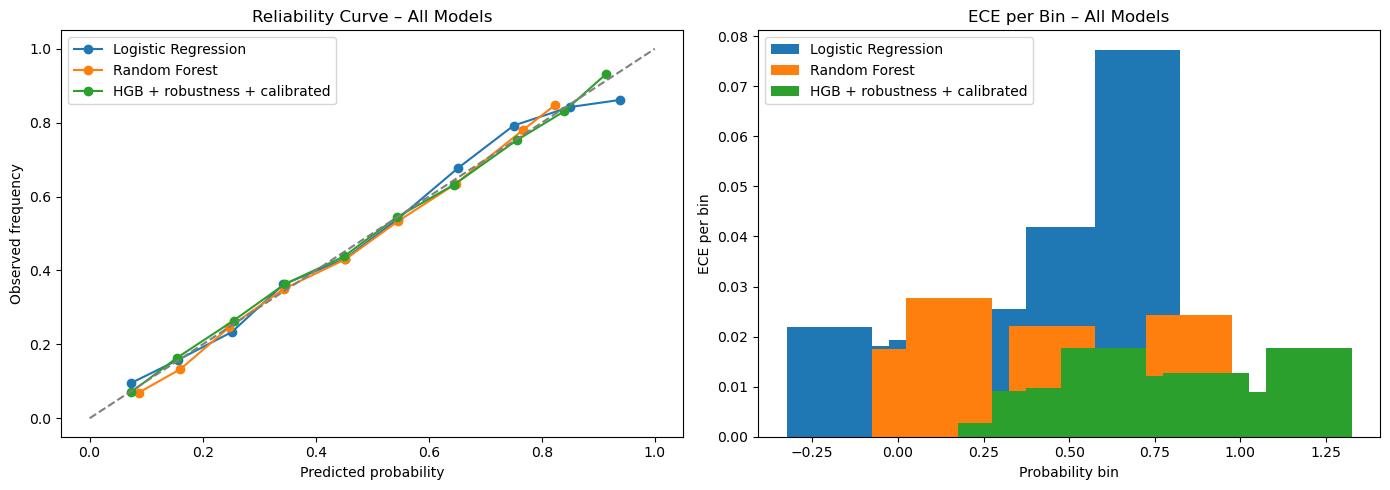

In [10]:
# Visualization
y_prob_lr = np.load("../data/processed/y_prob_lr.npy")
y_prob_rf = np.load("../data/processed/y_prob_rf.npy")

conf_lr, acc_lr, bins = compute_reliability_curve(y_test, y_prob_lr)
conf_rf, acc_rf, _ = compute_reliability_curve(y_test, y_prob_rf)
conf_hgb, acc_hgb, _ = compute_reliability_curve(y_test, y_prob_hgb)

models_data = [
    ("Logistic Regression", conf_lr, acc_lr),
    ("Random Forest", conf_rf, acc_rf),
    ("HGB + robustness + calibrated", conf_hgb, acc_hgb)
]

fig = plot_calibration_summary(models_data, bins)
fig.savefig("../reports/figures/calibration_summary.png", dpi=300)

In [12]:
# Bootstrap HGB
ci = compute_bootstrap_intervals(y_test, y_prob_hgb, n_iterations=1000)

roc_mean = ci["roc_auc_mean"]
roc_low, roc_high = ci["roc_auc_ci"]

pr_mean = ci["pr_auc_mean"]
pr_low, pr_high = ci["pr_auc_ci"]

print("Bootstrap 95% CI")
print(f"- ROC-AUC: {roc_mean:.3f} [{roc_low:.3f} – {roc_high:.3f}]")
print(f"- PR-AUC: {pr_mean:.3f} [{pr_low:.3f} – {pr_high:.3f}]")

Bootstrap 95% CI
- ROC-AUC: 0.789 [0.781 – 0.797]
- PR-AUC: 0.773 [0.761 – 0.783]


In [13]:
# Save final calibrated model
joblib.dump(calibrated, "../models/final_pipeline.joblib")

# Save test data
X_test.to_csv("../data/processed/X_test.csv", index=False)
y_test.to_csv("../data/processed/y_test.csv", index=False)

The selected model (**HGB with median imputation and isotonic calibration**) was chosen because it consistently achieved the best balance between discrimination and calibration, providing the most reliable cardiovascular risk estimates among all evaluated candidates.